# Simulator runner

In [36]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict
import os
import json
import pandas as pd
import numpy as np

In [37]:
from utilitysimv3 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_dumb_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_infer_profile, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [3]:
PROFILE_DIR = '/home/romilb/research/msr/results/profiling/waymo_phx/meta/profiles'
INFERENCE_MAX_DEFAULT = 0.25

In [16]:
def read_profiles(profile_dir, city_name):
    profile_path = os.path.join(profile_dir, "{}.json".format(city_name))
    with open(profile_path) as f:
        data = json.load(f)
    offset = int(sorted(data["taskwise_train_profiles"], key=lambda x: int(x))[0])
    print(offset)
    final_data = {"taskwise_train_profiles": {},
                  "taskwise_infer_profiles": {}}
    for key in data["taskwise_train_profiles"].keys():
        final_data["taskwise_train_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
    for key in data["taskwise_infer_profiles"].keys():
        final_data["taskwise_infer_profiles"][str(int(key)-offset)] = data["taskwise_infer_profiles"][key]
    assert "taskwise_train_profiles" in final_data
    assert "taskwise_infer_profiles" in final_data
    return final_data

In [17]:
city_name = "phx-21-40"
data = read_profiles(PROFILE_DIR, city_name)
TASKS = data["taskwise_train_profiles"].keys()

# Format = [Acc, res_time, 0]
train_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data["taskwise_train_profiles"][TASK_ID]] for TASK_ID in TASKS}

# TODO: Picking min profile, which else can we pick?
infer_profiles = {TASK_ID: min([acc for hp_id, acc in data["taskwise_infer_profiles"][TASK_ID].items()]) for TASK_ID in TASKS}

21


In [18]:
def create_cameras(city_names, profile_dir = PROFILE_DIR, inference_max_resources = INFERENCE_MAX_DEFAULT):
    cameras = []
    for city in city_names:        
        data = read_profiles(profile_dir, city)
        TASKS = data["taskwise_train_profiles"].keys()
        # Format = [Acc, res_time, 0]
        train_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data["taskwise_train_profiles"][TASK_ID]] for TASK_ID in TASKS}
        # TODO: Picking min profile, which else can we pick?
        infer_start_accs = {TASK_ID: min([acc for hp_id, acc in data["taskwise_infer_profiles"][TASK_ID].items()]) for TASK_ID in TASKS}

        cameras.append(Camera(str(city),
                              train_profiles,
                              infer_start_accs,
                              inference_max_resources=inference_max_resources
                             ))
    return cameras

In [19]:
train_profiles

{'0': [[0.8168724279835392, 8.626862049102783, 0],
  [0.7098765432098766, 25.56059241294861, 0],
  [0.8621399176954734, 15.02613377571106, 0],
  [0.6646090534979424, 7.0761284828186035, 0],
  [0.8312757201646092, 12.63124942779541, 0],
  [0.7469135802469137, 10.738077640533447, 0]],
 '1': [[0.938961038961039, 56.11647057533264, 0],
  [0.9103896103896104, 167.29205346107483, 0],
  [0.938961038961039, 114.30264067649841, 0],
  [0.9402597402597402, 48.076892614364624, 0],
  [0.938961038961039, 76.41865634918213, 0],
  [0.938961038961039, 74.29914164543152, 0]],
 '2': [[0.8607095926412616, 25.95917558670044, 0],
  [0.8620236530880421, 82.11161708831787, 0],
  [0.859395532194481, 53.29074192047119, 0],
  [0.8580814717477004, 21.19483518600464, 0],
  [0.8409986859395533, 37.32579159736633, 0],
  [0.8580814717477004, 32.54266881942749, 0]],
 '3': [[0.9483394833948339, 22.887725591659546, 0],
  [0.9151291512915128, 85.89568567276001, 0],
  [0.8966789667896679, 51.856069564819336, 0],
  [0.9335

In [20]:
x=create_cameras(["phx-21-40"])

21


In [21]:
cfgs=x[0].generate_training_configurations("1")

In [42]:
len(cfgs)

5

## Run comparison

In [43]:
data = []
allocation = defaultdict(dict)
periods_to_test = [100]#, 200, 400]
provisioned_res_to_test = [1,2,4,8,16]#,32,64]#[1,2,4,8,16]#list(np.arange(0,1,0.05))#
camera_names = ["phx-21-40", "phx-41-60"]*5
task_ids = [str(x) for x in range(1,6)]
INFER_MAX_RES = 0.25

schedulers_to_test = [(fair_dumb_scheduler, 'fair_dumb'),
                      (fair_naive_scheduler, 'fair_naive'),
                     (fair_sco_scheduler, 'fair_sco'),
                     (lambda x,y,z: thief_sco_scheduler(x,y,z,iterations=3,steal_increment=INFER_MAX_RES/3), 'thief'),
                     (inference_only_scheduler, 'inference_only')
                     ]

column_names = ['period', 'resources', *[sched_name for _, sched_name in schedulers_to_test]]
for retraining_period in periods_to_test:
    for provisioned_res in provisioned_res_to_test:
        this_config_result = [retraining_period, provisioned_res]
        print("Resources: {}".format(provisioned_res))
        print("Period: {}".format(retraining_period))
        for scheduler, sched_name in schedulers_to_test:
            cameras = create_cameras(camera_names, inference_max_resources = INFER_MAX_RES)
            mps = MultiPeriodSimulator(cameras, provisioned_res, scheduler, retraining_period, task_ids = task_ids)
            results, period_allocation_log = mps.step_till_completion()
            this_config_result.append(results['meta']['overall_inf_mean_auc'])
            allocation["{}_{}_{}".format(retraining_period, provisioned_res, sched_name)] = period_allocation_log
        data.append(this_config_result)
        
#         df = pd.DataFrame(data, columns=column_names)
#         df.to_pickle('temp2.pdpickle')

50
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
100
Job phx-41-60_train_0 is done.
Simulator steps done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.


Resources: 1
Period: 100
21
41
21
41
21
41
21
41
21
41
Running task 1
Running task 2


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
50
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job p

Running task 3
Running task 4
Running task 5
21
41
21
41
21
41
21
41
21


50
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
100
Job phx-41-60_train_0 is done.
Simulator steps done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41

41
Running task 1
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running task 2


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
50
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job p

Running task 3
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running task 4
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.


Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
100
Job phx-21-40_train_2 is done.
Simulator steps done.
50
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41

Running task 5
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
21
41
21
41
21
41
21
41
21
41
Running task 1


50
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
100
Job phx-41-60_train_3 is done.
Simulator steps done.


Running task 2


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 3


50
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
100
Job phx-21-40_train_3 is done.
Simulator steps done.


Running task 4


50
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job p

Running task 5


50
100
Simulator steps done.


21
41
21
41
21
41
21
41
21
41
Running task 1
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac8d898>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46ead3a710>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eacc1f28>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eacc7240>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eacb0668>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eacbfef0>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eacb06d8>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eacb0160>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eac8d4e0>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eac8da58>: [0.05, 0.05]}
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: ph

Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
50
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job p

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac8d898>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46ead3a710>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eacc1f28>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacc7240>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eacb0668>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacbfef0>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eacb06d8>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacb0160>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eac8d4e0>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eac8da58>: [0.25, 0.5]}
Running task 2
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac8d898>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46ead3a710>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eacc1f28>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eacc7240>: [0.05, 0.05], <util

Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac8d898>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46ead3a710>: [0.16666666666666669, 0.5833333333333334], <utilitysimv3.InferenceJob object at 0x7f46eacc1f28>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacc7240>: [0.16666666666666669, 0.5833333333333334], <utilitysimv3.InferenceJob object at 0x7f46eacb0668>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacbfef0>: [0.16666666666666669, 0.5833333333333334], <utilitysimv3.InferenceJob object at 0x7f46eacb06d8>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacb0160>: [0.16666666666666669, 0.5833333333333334], <utilitysimv3.InferenceJob object at 0x7f46eac8d4e0>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eac8da58>: [0.16666666666666669, 0.5833333333333334]}
Running task 3
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac8d898>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46ead3a710>: [0.05

Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
50
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job p

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac8d898>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46ead3a710>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacc1f28>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eacc7240>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacb0668>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eacbfef0>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacb06d8>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eacb0160>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eac8d4e0>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eac8da58>: [0.25, 0.0]}
Running task 4
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac8d898>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46ead3a710>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eacc1f28>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46eacc7240>: [0.05, 0.05], <util

Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
50
Job phx-21-40_train_4 is done.
Job p

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac8d898>: [0.0, 0.8333333333333334], <utilitysimv3.InferenceJob object at 0x7f46ead3a710>: [0.16666666666666669, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacc1f28>: [0.0, 0.8333333333333334], <utilitysimv3.InferenceJob object at 0x7f46eacc7240>: [0.16666666666666669, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacb0668>: [0.0, 0.8333333333333334], <utilitysimv3.InferenceJob object at 0x7f46eacbfef0>: [0.16666666666666669, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacb06d8>: [0.0, 0.8333333333333334], <utilitysimv3.InferenceJob object at 0x7f46eacb0160>: [0.16666666666666669, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eac8d4e0>: [0.0, 0.8333333333333334], <utilitysimv3.InferenceJob object at 0x7f46eac8da58>: [0.16666666666666669, 0.0]}
Running task 5
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac8d898>: [0.05, 0.05], <utilitysimv3.InferenceJob object at 0x7f46ead3a710>: [0.05, 0.0

50
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job p

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac8d898>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46ead3a710>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eacc1f28>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacc7240>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eacb0668>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacbfef0>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eacb06d8>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacb0160>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eac8d4e0>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eac8da58>: [0.25, 0.5]}
21
41
21
41
21
41
21
41
21
41
Running task 1
Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
50
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.


Running task 4
Running task 5
Resources: 2
Period: 100
21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 2


100
Job phx-41-60_train_0 is done.
Simulator steps done.
50
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
100
Job ph

Running task 3
Running task 4


Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-

Running task 5
21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-

Running task 2


Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 3
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running task 4
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.


Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-

Running task 5
21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
50
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job p

Running task 2


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 3


Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
50
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job p

Running task 4


Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
50
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job p

Running task 5


50
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job p

21
41
21
41
21
41
21
41
21
41
Running task 1
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac3ab70>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46ead21518>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46eabe8630>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46eac3acc0>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f43f7f98>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f33a47f0>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f33739b0>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f32d0a90>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f33731d0>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f32d16a0>: [0.1, 0.1]}
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_0
Best

Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac3ab70>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46ead21518>: [0.33333333333333337, 1.4166666666666667], <utilitysimv3.InferenceJob object at 0x7f46eabe8630>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eac3acc0>: [0.33333333333333337, 1.4166666666666667], <utilitysimv3.InferenceJob object at 0x7f46f43f7f98>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f33a47f0>: [0.33333333333333337, 1.4166666666666667], <utilitysimv3.InferenceJob object at 0x7f46f33739b0>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f32d0a90>: [0.33333333333333337, 1.4166666666666667], <utilitysimv3.InferenceJob object at 0x7f46f33731d0>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f32d16a0>: [0.33333333333333337, 1.4166666666666667]}
Running task 2
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac3ab70>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46ead21518>: [0.1, 0

Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac3ab70>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46ead21518>: [0.25, 1.0], <utilitysimv3.InferenceJob object at 0x7f46eabe8630>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46eac3acc0>: [0.25, 1.0], <utilitysimv3.InferenceJob object at 0x7f46f43f7f98>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46f33a47f0>: [0.25, 1.0], <utilitysimv3.InferenceJob object at 0x7f46f33739b0>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46f32d0a90>: [0.25, 1.0], <utilitysimv3.InferenceJob object at 0x7f46f33731d0>: [0.25, 0.5], <utilitysimv3.InferenceJob object at 0x7f46f32d16a0>: [0.25, 1.0]}


Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 3
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac3ab70>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46ead21518>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46eabe8630>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46eac3acc0>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f43f7f98>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f33a47f0>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f33739b0>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f32d0a90>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f33731d0>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46f32d16a0>: [0.1, 0.1]}
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inferenc

Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac3ab70>: [0.25, 1.5], <utilitysimv3.InferenceJob object at 0x7f46ead21518>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eabe8630>: [0.25, 1.5], <utilitysimv3.InferenceJob object at 0x7f46eac3acc0>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f43f7f98>: [0.25, 1.5], <utilitysimv3.InferenceJob object at 0x7f46f33a47f0>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f33739b0>: [0.25, 1.5], <utilitysimv3.InferenceJob object at 0x7f46f32d0a90>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f33731d0>: [0.25, 1.5], <utilitysimv3.InferenceJob object at 0x7f46f32d16a0>: [0.25, 0.0]}
Running task 4
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac3ab70>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46ead21518>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46eabe8630>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46eac3acc0>: [0.1, 0.1], <utilitysimv3

Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac3ab70>: [0.0, 1.8333333333333333], <utilitysimv3.InferenceJob object at 0x7f46ead21518>: [0.16666666666666669, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eabe8630>: [0.0, 1.8333333333333333], <utilitysimv3.InferenceJob object at 0x7f46eac3acc0>: [0.16666666666666669, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f43f7f98>: [0.0, 1.8333333333333333], <utilitysimv3.InferenceJob object at 0x7f46f33a47f0>: [0.16666666666666669, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f33739b0>: [0.0, 1.8333333333333333], <utilitysimv3.InferenceJob object at 0x7f46f32d0a90>: [0.16666666666666669, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f33731d0>: [0.0, 1.8333333333333333], <utilitysimv3.InferenceJob object at 0x7f46f32d16a0>: [0.16666666666666669, 0.0]}
Running task 5
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac3ab70>: [0.1, 0.1], <utilitysimv3.InferenceJob object at 0x7f46ead21518>: [0.1, 0.1], 

Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
50
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job p

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46eac3ab70>: [0.25, 1.5], <utilitysimv3.InferenceJob object at 0x7f46ead21518>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eabe8630>: [0.25, 1.5], <utilitysimv3.InferenceJob object at 0x7f46eac3acc0>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f43f7f98>: [0.25, 1.5], <utilitysimv3.InferenceJob object at 0x7f46f33a47f0>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f33739b0>: [0.25, 1.5], <utilitysimv3.InferenceJob object at 0x7f46f32d0a90>: [0.25, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f33731d0>: [0.25, 1.5], <utilitysimv3.InferenceJob object at 0x7f46f32d16a0>: [0.25, 0.0]}
21
41
21
41
21


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50


41
21
41
21
41
Running task 1
Running task 2
Running task 3
Running task 4
Running task 5


100
Simulator steps done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60

Resources: 4
Period: 100
21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-

Running task 2


Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
100
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Simulator steps done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40

Running task 3


Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
100
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Simulator steps done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40

Running task 4


Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
100
Job phx-21-40_train_2 is done.
Simulator steps done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
50
Job phx-41

Running task 5


Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
100
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Simulator steps done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40

21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-

Running task 2


Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-

Running task 3


Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
100
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Simulator steps done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-21-40

Running task 4


Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_4 is done.
100
Job phx-21-40_train_2 is done.
Job 

Running task 5


Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
100
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Simu

21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
50
Job phx-41-60_train_3 is done.
Job p

Running task 2


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-

Running task 3


Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
50
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job p

Running task 4


Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-

Running task 5


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
50
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job p

21
41
21
41
21
41
21
41
21
41
Running task 1
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f32b7e10>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f112d860>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46eacc5be0>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f3380a58>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46eac3ae48>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f321a630>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32ecda0>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32ec240>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f110ed30>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32d1240>: [0.2, 0.2]}
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_3
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_3
Best config for phx-21-40_inference: phx-21-40_train_0
Best

Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f32b7e10>: [0.5, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f112d860>: [0.6666666666666667, 2.8333333333333335], <utilitysimv3.InferenceJob object at 0x7f46eacc5be0>: [0.5, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f3380a58>: [0.6666666666666667, 2.8333333333333335], <utilitysimv3.InferenceJob object at 0x7f46eac3ae48>: [0.5, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f321a630>: [0.6666666666666667, 2.8333333333333335], <utilitysimv3.InferenceJob object at 0x7f46f32ecda0>: [0.5, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f32ec240>: [0.6666666666666667, 2.8333333333333335], <utilitysimv3.InferenceJob object at 0x7f46f110ed30>: [0.5, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f32d1240>: [0.6666666666666667, 2.8333333333333335]}


Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
100
Job 

Running task 2
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f32b7e10>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f112d860>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46eacc5be0>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f3380a58>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46eac3ae48>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f321a630>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32ecda0>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32ec240>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f110ed30>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32d1240>: [0.2, 0.2]}
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_3
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_3
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inferenc

Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f32b7e10>: [0.25000000000000006, 1.4166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f112d860>: [0.25, 2.0833333333333335], <utilitysimv3.InferenceJob object at 0x7f46eacc5be0>: [0.25000000000000006, 1.4166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f3380a58>: [0.25, 2.0833333333333335], <utilitysimv3.InferenceJob object at 0x7f46eac3ae48>: [0.25000000000000006, 1.4166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f321a630>: [0.25, 2.0833333333333335], <utilitysimv3.InferenceJob object at 0x7f46f32ecda0>: [0.25000000000000006, 1.4166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f32ec240>: [0.25, 2.0833333333333335], <utilitysimv3.InferenceJob object at 0x7f46f110ed30>: [0.25000000000000006, 1.4166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f32d1240>: [0.25, 2.0833333333333335]}


Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-

Running task 3
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f32b7e10>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f112d860>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46eacc5be0>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f3380a58>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46eac3ae48>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f321a630>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32ecda0>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32ec240>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f110ed30>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32d1240>: [0.2, 0.2]}
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inferenc

Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f32b7e10>: [0.25, 2.583333333333333], <utilitysimv3.InferenceJob object at 0x7f46f112d860>: [0.25, 0.9166666666666667], <utilitysimv3.InferenceJob object at 0x7f46eacc5be0>: [0.25, 2.583333333333333], <utilitysimv3.InferenceJob object at 0x7f46f3380a58>: [0.25, 0.9166666666666667], <utilitysimv3.InferenceJob object at 0x7f46eac3ae48>: [0.25, 2.583333333333333], <utilitysimv3.InferenceJob object at 0x7f46f321a630>: [0.25, 0.9166666666666667], <utilitysimv3.InferenceJob object at 0x7f46f32ecda0>: [0.25, 2.583333333333333], <utilitysimv3.InferenceJob object at 0x7f46f32ec240>: [0.25, 0.9166666666666667], <utilitysimv3.InferenceJob object at 0x7f46f110ed30>: [0.25, 2.583333333333333], <utilitysimv3.InferenceJob object at 0x7f46f32d1240>: [0.25, 0.9166666666666667]}


Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 4
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f32b7e10>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f112d860>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46eacc5be0>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f3380a58>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46eac3ae48>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f321a630>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32ecda0>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32ec240>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f110ed30>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32d1240>: [0.2, 0.2]}
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inferenc

Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f32b7e10>: [0.25, 3.25], <utilitysimv3.InferenceJob object at 0x7f46f112d860>: [0.25, 0.2500000000000001], <utilitysimv3.InferenceJob object at 0x7f46eacc5be0>: [0.25, 3.25], <utilitysimv3.InferenceJob object at 0x7f46f3380a58>: [0.25, 0.2500000000000001], <utilitysimv3.InferenceJob object at 0x7f46eac3ae48>: [0.25, 3.25], <utilitysimv3.InferenceJob object at 0x7f46f321a630>: [0.25, 0.2500000000000001], <utilitysimv3.InferenceJob object at 0x7f46f32ecda0>: [0.25, 3.25], <utilitysimv3.InferenceJob object at 0x7f46f32ec240>: [0.25, 0.2500000000000001], <utilitysimv3.InferenceJob object at 0x7f46f110ed30>: [0.25, 3.25], <utilitysimv3.InferenceJob object at 0x7f46f32d1240>: [0.25, 0.2500000000000001]}


Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 5
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f32b7e10>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f112d860>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46eacc5be0>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f3380a58>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46eac3ae48>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f321a630>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32ecda0>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32ec240>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f110ed30>: [0.2, 0.2], <utilitysimv3.InferenceJob object at 0x7f46f32d1240>: [0.2, 0.2]}
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inferenc

Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
50
Job p

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f32b7e10>: [0.25, 3.333333333333333], <utilitysimv3.InferenceJob object at 0x7f46f112d860>: [0.41666666666666674, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eacc5be0>: [0.25, 3.333333333333333], <utilitysimv3.InferenceJob object at 0x7f46f3380a58>: [0.41666666666666674, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eac3ae48>: [0.25, 3.333333333333333], <utilitysimv3.InferenceJob object at 0x7f46f321a630>: [0.41666666666666674, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f32ecda0>: [0.25, 3.333333333333333], <utilitysimv3.InferenceJob object at 0x7f46f32ec240>: [0.41666666666666674, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f110ed30>: [0.25, 3.333333333333333], <utilitysimv3.InferenceJob object at 0x7f46f32d1240>: [0.41666666666666674, 0.0]}


Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
100
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50


21
41
21
41
21
41
21
41
21
41
Running task 1
Running task 2
Running task 3
Running task 4


100
Simulator steps done.
50
100
Simulator steps done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_t

Running task 5
Resources: 8
Period: 100
21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
50
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job p

Running task 2


Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 3


Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 4


Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-

Running task 5


Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-

21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
50
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job p

Running task 2


Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 3


Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 4


Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-

Running task 5


Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-

21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-

Running task 2


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-

Running task 3


Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-

Running task 4


Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-

Running task 5


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-

21
41
21
41
21
41
21
41
21
41
Running task 1
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f320efd0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eace26d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f32b79b0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eabe8898>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f32d06d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eac23fd0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f110ebe0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f3380048>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f1120d30>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eac3aa90>: [0.4, 0.4]}
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_3
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_3
Best config for phx-21-40_inference: phx-21-40_train_0
Best

Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f320efd0>: [1.0, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eace26d8>: [0.41666666666666674, 6.583333333333333], <utilitysimv3.InferenceJob object at 0x7f46f32b79b0>: [1.0, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eabe8898>: [0.41666666666666674, 6.583333333333333], <utilitysimv3.InferenceJob object at 0x7f46f32d06d8>: [1.0, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eac23fd0>: [0.41666666666666674, 6.583333333333333], <utilitysimv3.InferenceJob object at 0x7f46f110ebe0>: [1.0, 0.0], <utilitysimv3.InferenceJob object at 0x7f46f3380048>: [0.41666666666666674, 6.583333333333333], <utilitysimv3.InferenceJob object at 0x7f46f1120d30>: [1.0, 0.0], <utilitysimv3.InferenceJob object at 0x7f46eac3aa90>: [0.41666666666666674, 6.583333333333333]}


Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_3 is done.
Job phx-

Running task 2
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f320efd0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eace26d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f32b79b0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eabe8898>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f32d06d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eac23fd0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f110ebe0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f3380048>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f1120d30>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eac3aa90>: [0.4, 0.4]}
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inferenc

Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f320efd0>: [0.75, 2.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46eace26d8>: [0.41666666666666674, 3.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f32b79b0>: [0.75, 2.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46eabe8898>: [0.41666666666666674, 3.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f32d06d8>: [0.75, 2.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46eac23fd0>: [0.41666666666666674, 3.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f110ebe0>: [0.75, 2.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f3380048>: [0.41666666666666674, 3.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f1120d30>: [0.75, 2.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46eac3aa90>: [0.41666666666666674, 3.9166666666666665]}


Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 3
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f320efd0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eace26d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f32b79b0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eabe8898>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f32d06d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eac23fd0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f110ebe0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f3380048>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f1120d30>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eac3aa90>: [0.4, 0.4]}
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inferenc

Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f320efd0>: [0.25, 6.083333333333333], <utilitysimv3.InferenceJob object at 0x7f46eace26d8>: [0.33333333333333337, 1.3333333333333335], <utilitysimv3.InferenceJob object at 0x7f46f32b79b0>: [0.25, 6.083333333333333], <utilitysimv3.InferenceJob object at 0x7f46eabe8898>: [0.33333333333333337, 1.3333333333333335], <utilitysimv3.InferenceJob object at 0x7f46f32d06d8>: [0.25, 6.083333333333333], <utilitysimv3.InferenceJob object at 0x7f46eac23fd0>: [0.33333333333333337, 1.3333333333333335], <utilitysimv3.InferenceJob object at 0x7f46f110ebe0>: [0.25, 6.083333333333333], <utilitysimv3.InferenceJob object at 0x7f46f3380048>: [0.33333333333333337, 1.3333333333333335], <utilitysimv3.InferenceJob object at 0x7f46f1120d30>: [0.25, 6.083333333333333], <utilitysimv3.InferenceJob object at 0x7f46eac3aa90>: [0.33333333333333337, 1.3333333333333335]}


Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
100
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Simulator steps done.


Running task 4
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f320efd0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eace26d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f32b79b0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eabe8898>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f32d06d8>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eac23fd0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f110ebe0>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f3380048>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46f1120d30>: [0.4, 0.4], <utilitysimv3.InferenceJob object at 0x7f46eac3aa90>: [0.4, 0.4]}
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inferenc

Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f320efd0>: [0.3333333333333335, 5.499999999999999], <utilitysimv3.InferenceJob object at 0x7f46eace26d8>: [0.2500000000000001, 1.9166666666666667], <utilitysimv3.InferenceJob object at 0x7f46f32b79b0>: [0.3333333333333335, 5.499999999999999], <utilitysimv3.InferenceJob object at 0x7f46eabe8898>: [0.2500000000000001, 1.9166666666666667], <utilitysimv3.InferenceJob object at 0x7f46f32d06d8>: [0.3333333333333335, 5.499999999999999], <utilitysimv3.InferenceJob object at 0x7f46eac23fd0>: [0.2500000000000001, 1.9166666666666667], <utilitysimv3.InferenceJob object at 0x7f46f110ebe0>: [0.3333333333333335, 5.499999999999999], <utilitysimv3.InferenceJob object at 0x7f46f3380048>: [0.2500000000000001, 1.9166666666666667], <utilitysimv3.InferenceJob object at 0x7f46f1120d30>: [0.3333333333333335, 5.499999999999999], <utilitysimv3.InferenceJob object at 0x7f46eac3aa90>: [0.2500000000000001, 1.9166666666666667]}
Running task 5
Iter 0, 

Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f320efd0>: [0.25000000000000017, 6.833333333333333], <utilitysimv3.InferenceJob object at 0x7f46eace26d8>: [0.33333333333333337, 0.5833333333333333], <utilitysimv3.InferenceJob object at 0x7f46f32b79b0>: [0.25000000000000017, 6.833333333333333], <utilitysimv3.InferenceJob object at 0x7f46eabe8898>: [0.33333333333333337, 0.5833333333333333], <utilitysimv3.InferenceJob object at 0x7f46f32d06d8>: [0.25000000000000017, 6.833333333333333], <utilitysimv3.InferenceJob object at 0x7f46eac23fd0>: [0.33333333333333337, 0.5833333333333333], <utilitysimv3.InferenceJob object at 0x7f46f110ebe0>: [0.25000000000000017, 6.833333333333333], <utilitysimv3.InferenceJob object at 0x7f46f3380048>: [0.33333333333333337, 0.5833333333333333], <utilitysimv3.InferenceJob object at 0x7f46f1120d30>: [0.25000000000000017, 6.833333333333333], <utilitysimv3.InferenceJob object at 0x7f46eac3aa90>: [0.33333333333333337, 0.5833333333333333]}
21
41
21
41
2

100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train

Running task 3
Running task 4
Running task 5
Resources: 16
Period: 100
21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-

Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-

Running task 2
Running task 3


Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-

Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
100
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Simulator steps done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40

Running task 4
Running task 5


Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-

Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_3 is done.
Job phx-

21
41
21
41
21
41
21
41
21
41
Running task 1
Running task 2


Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_1 is done.
Job phx-

Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 3
Running task 4


Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-21-40_train_2 is done.
Job phx-41-60_train_2 is done.
Job phx-

Running task 5
21
41
21
41
21
41
21
41
21
41
Running task 1


Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-

Running task 2


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-

Running task 3


Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-

Running task 4


Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-

Running task 5


Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-

21
41
21
41
21
41
21
41
21
41
Running task 1
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f3380780>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3367eb8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f32216d8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46eacb3668>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f33675f8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f320e2e8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46eabe8438>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3367710>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46eabe8b38>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3235278>: [0.8, 0.8]}
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_3
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_3
Best config for phx-21-40_inference: phx-21-40_train_3
Best

Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-21-40_train_3 is done.
Job phx-41-60_train_3 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f3380780>: [1.5, 3.75], <utilitysimv3.InferenceJob object at 0x7f46f3367eb8>: [0.8333333333333335, 9.916666666666666], <utilitysimv3.InferenceJob object at 0x7f46f32216d8>: [1.5, 3.75], <utilitysimv3.InferenceJob object at 0x7f46eacb3668>: [0.8333333333333335, 9.916666666666666], <utilitysimv3.InferenceJob object at 0x7f46f33675f8>: [1.5, 3.75], <utilitysimv3.InferenceJob object at 0x7f46f320e2e8>: [0.8333333333333335, 9.916666666666666], <utilitysimv3.InferenceJob object at 0x7f46eabe8438>: [1.5, 3.75], <utilitysimv3.InferenceJob object at 0x7f46f3367710>: [0.8333333333333335, 9.916666666666666], <utilitysimv3.InferenceJob object at 0x7f46eabe8b38>: [1.5, 3.75], <utilitysimv3.InferenceJob object at 0x7f46f3235278>: [0.8333333333333335, 9.916666666666666]}
Running task 2
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f3380780>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3367eb8>: [0.8, 0.8], <util

Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f3380780>: [2.5, 7.833333333333333], <utilitysimv3.InferenceJob object at 0x7f46f3367eb8>: [1.666666666666667, 4.0], <utilitysimv3.InferenceJob object at 0x7f46f32216d8>: [2.5, 7.833333333333333], <utilitysimv3.InferenceJob object at 0x7f46eacb3668>: [1.666666666666667, 4.0], <utilitysimv3.InferenceJob object at 0x7f46f33675f8>: [2.5, 7.833333333333333], <utilitysimv3.InferenceJob object at 0x7f46f320e2e8>: [1.666666666666667, 4.0], <utilitysimv3.InferenceJob object at 0x7f46eabe8438>: [2.5, 7.833333333333333], <utilitysimv3.InferenceJob object at 0x7f46f3367710>: [1.666666666666667, 4.0], <utilitysimv3.InferenceJob object at 0x7f46eabe8b38>: [2.5, 7.833333333333333], <utilitysimv3.InferenceJob object at 0x7f46f3235278>: [1.666666666666667, 4.0]}


Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_0 is done.
Job phx-41-60_train_0 is done.
50
Job p

Running task 3
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f3380780>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3367eb8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f32216d8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46eacb3668>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f33675f8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f320e2e8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46eabe8438>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3367710>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46eabe8b38>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3235278>: [0.8, 0.8]}
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_0
Best config for phx-41-60_inferenc

Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f3380780>: [0.5833333333333335, 12.25], <utilitysimv3.InferenceJob object at 0x7f46f3367eb8>: [0.25, 2.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f32216d8>: [0.5833333333333335, 12.25], <utilitysimv3.InferenceJob object at 0x7f46eacb3668>: [0.25, 2.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46f33675f8>: [0.5833333333333335, 12.25], <utilitysimv3.InferenceJob object at 0x7f46f320e2e8>: [0.25, 2.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46eabe8438>: [0.5833333333333335, 12.25], <utilitysimv3.InferenceJob object at 0x7f46f3367710>: [0.25, 2.9166666666666665], <utilitysimv3.InferenceJob object at 0x7f46eabe8b38>: [0.5833333333333335, 12.25], <utilitysimv3.InferenceJob object at 0x7f46f3235278>: [0.25, 2.9166666666666665]}
Running task 4
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f3380780>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3367eb8>: [0

Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f3380780>: [0.3333333333333335, 8.333333333333332], <utilitysimv3.InferenceJob object at 0x7f46f3367eb8>: [1.166666666666667, 6.166666666666666], <utilitysimv3.InferenceJob object at 0x7f46f32216d8>: [0.3333333333333335, 8.333333333333332], <utilitysimv3.InferenceJob object at 0x7f46eacb3668>: [1.166666666666667, 6.166666666666666], <utilitysimv3.InferenceJob object at 0x7f46f33675f8>: [0.3333333333333335, 8.333333333333332], <utilitysimv3.InferenceJob object at 0x7f46f320e2e8>: [1.166666666666667, 6.166666666666666], <utilitysimv3.InferenceJob object at 0x7f46eabe8438>: [0.3333333333333335, 8.333333333333332], <utilitysimv3.InferenceJob object at 0x7f46f3367710>: [1.166666666666667, 6.166666666666666], <utilitysimv3.InferenceJob object at 0x7f46eabe8b38>: [0.3333333333333335, 8.333333333333332], <utilitysimv3.InferenceJob object at 0x7f46f3235278>: [1.166666666666667, 6.166666666666666]}


Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_4 is done.
Job phx-

Running task 5
Iter 0, alloc: {<utilitysimv3.InferenceJob object at 0x7f46f3380780>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3367eb8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f32216d8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46eacb3668>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f33675f8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f320e2e8>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46eabe8438>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3367710>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46eabe8b38>: [0.8, 0.8], <utilitysimv3.InferenceJob object at 0x7f46f3235278>: [0.8, 0.8]}
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inference: phx-41-60_train_0
Best config for phx-21-40_inference: phx-21-40_train_3
Best config for phx-41-60_inferenc

Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-41-60_train_0 is done.
Job phx-21-40_train_4 is done.
Job phx-

Iter 2, final_alloc: {<utilitysimv3.InferenceJob object at 0x7f46f3380780>: [0.25, 13.5], <utilitysimv3.InferenceJob object at 0x7f46f3367eb8>: [0.75, 1.5], <utilitysimv3.InferenceJob object at 0x7f46f32216d8>: [0.25, 13.5], <utilitysimv3.InferenceJob object at 0x7f46eacb3668>: [0.75, 1.5], <utilitysimv3.InferenceJob object at 0x7f46f33675f8>: [0.25, 13.5], <utilitysimv3.InferenceJob object at 0x7f46f320e2e8>: [0.75, 1.5], <utilitysimv3.InferenceJob object at 0x7f46eabe8438>: [0.25, 13.5], <utilitysimv3.InferenceJob object at 0x7f46f3367710>: [0.75, 1.5], <utilitysimv3.InferenceJob object at 0x7f46eabe8b38>: [0.25, 13.5], <utilitysimv3.InferenceJob object at 0x7f46f3235278>: [0.75, 1.5]}
21
41
21
41
21
41
21
41
21
41
Running task 1


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
Running task 3
Running task 4
Running task 5


In [44]:
df = pd.DataFrame(data, columns=column_names)

In [45]:
df

,period,resources,fair_dumb,fair_naive,fair_sco,thief,inference_only
0,100,1,0.808843,0.838147,0.854213,0.892025,0.544603
1,100,2,0.863397,0.881903,0.886534,0.916910,0.724856
2,100,4,0.899551,0.901158,0.912906,0.929610,0.767043
3,100,8,0.920806,0.920806,0.925545,0.936204,0.767043
4,100,16,0.931560,0.931560,0.934254,0.939185,0.767043


In [46]:
# import json
# df.to_pickle('scheduler_compare_result_ganeshprofiles_20cams.pdpickle')
# with open('scheduler_periodalloc_result_ganeshprofiles_20cams.json', 'w') as f:
#     json.dump(allocation, f)

# Visualization

### Comparison

In [47]:
df

,period,resources,fair_dumb,fair_naive,fair_sco,thief,inference_only
0,100,1,0.808843,0.838147,0.854213,0.892025,0.544603
1,100,2,0.863397,0.881903,0.886534,0.916910,0.724856
2,100,4,0.899551,0.901158,0.912906,0.929610,0.767043
3,100,8,0.920806,0.920806,0.925545,0.936204,0.767043
4,100,16,0.931560,0.931560,0.934254,0.939185,0.767043


<IPython.core.display.Javascript object>


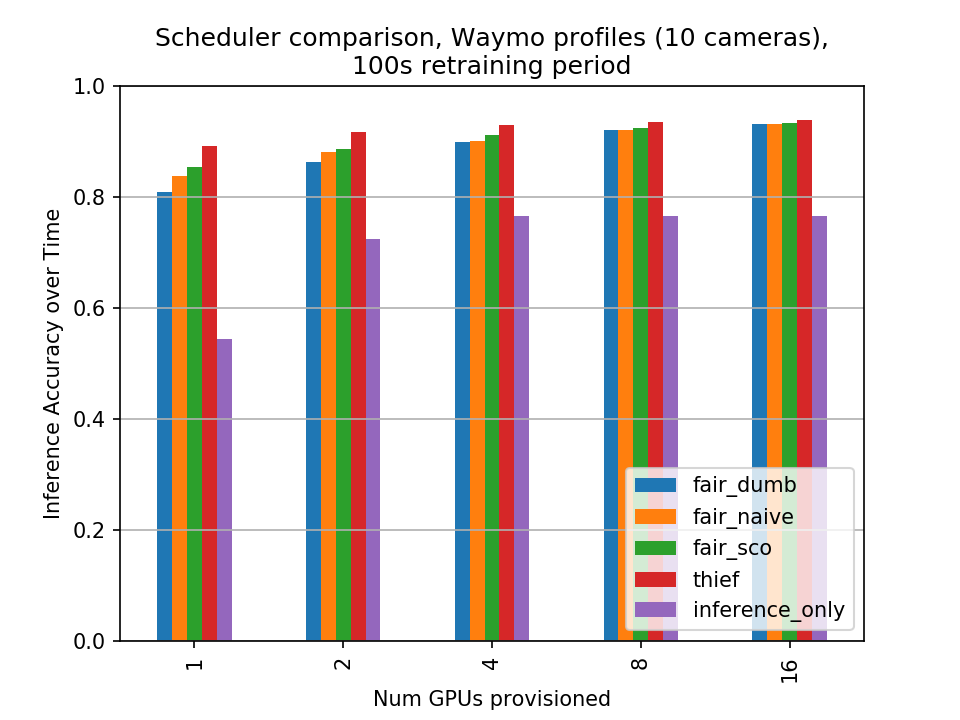

In [48]:
for PERIOD in [100]:#, 100]:#, 100, 200, 400]:
    sched_names = [sched_name for _, sched_name in schedulers_to_test if sched_name!='fair_random']
    const_res_data = df[df['period'] == PERIOD]
    ax = const_res_data.plot(x='resources', y=sched_names, kind='bar',
                        title ="Scheduler comparison, Waymo profiles ({} cameras),\n{}s retraining period".format(len(camera_names), PERIOD),
                        legend=True)
    ax.set_xlabel("Num GPUs provisioned")
    ax.set_ylabel("Inference Accuracy over Time")
    ax.set_ylim([0,1])
    ax.legend(loc='lower right')
    ax.grid(axis='y')
    plt.savefig('/tmp/schedcompare_{}.pdf'.format(PERIOD))

In [35]:
#print(allocation['50_1_thief']["1"])
print(allocation['50_1_fair_sco']["1"])
#allocation['50_1_inference_only']

{0: {'zurich_train_0': 0.05, 'aachen_train_33': 0.05, 'stuttgart_train_0': 0.05, 'darmstadt_train_27': 0.05, 'dusseldorf_train_24': 0.05, 'tubingen_train_18': 0.05, 'bremen_train_20': 0.05, 'ulm_train_18': 0.05, 'cologne_train_21': 0.05, 'jena_train_33': 0.05, 'zurich_inference': 0.05, 'aachen_inference': 0.05, 'stuttgart_inference': 0.05, 'darmstadt_inference': 0.05, 'dusseldorf_inference': 0.05, 'tubingen_inference': 0.05, 'bremen_inference': 0.05, 'ulm_inference': 0.05, 'cologne_inference': 0.05, 'jena_inference': 0.05}, 11.665301322937012: {'ulm_train_18': 0, 'zurich_train_0': 0.052631578947368425, 'aachen_train_33': 0.052631578947368425, 'stuttgart_train_0': 0.052631578947368425, 'darmstadt_train_27': 0.052631578947368425, 'dusseldorf_train_24': 0.052631578947368425, 'tubingen_train_18': 0.052631578947368425, 'bremen_train_20': 0.052631578947368425, 'cologne_train_21': 0.052631578947368425, 'jena_train_33': 0.052631578947368425, 'zurich_inference': 0.052631578947368425, 'aachen_in

In [36]:
pd.DataFrame(allocation['50_1_fair_sco']["1"])

,0.0,11.665301322937012,16.06399440765381,27.941957473754883,30.0522243976593,50.50085949897766,54.90025448799133,80.0557234287262,84.54527997970581,99.77826738357544,111.8617308139801
aachen_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
aachen_train_33,0.05,0.052632,0.055556,0.058824,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
bremen_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
bremen_train_20,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.000000,0.0
cologne_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
cologne_train_21,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.0
darmstadt_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
darmstadt_train_27,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.000000,0.000000,0.0
dusseldorf_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
dusseldorf_train_24,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.000000,0.000000,0.000000,0.0


In [37]:
pd.DataFrame(allocation['50_1_thief']["1"])

,0.0,11.665301322937012,14.631958484649658,15.572422504425049,15.96550178527832,16.816251754760742,27.765329360961914,29.712453365325928,30.32125186920166,31.800294876098633,34.956321239471436
aachen_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
aachen_train_18,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.000000,0.000000,0.000000,0.000000,0.0
bremen_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
bremen_train_18,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.0
cologne_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
cologne_train_18,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.000000,0.000000,0.000000,0.0
darmstadt_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
darmstadt_train_18,0.05,0.052632,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
dusseldorf_inference,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.090909,0.1
dusseldorf_train_18,0.05,0.052632,0.055556,0.058824,0.0625,0.066667,0.071429,0.076923,0.083333,0.000000,0.0


### Accuracy progression

In [ ]:
plt.figure()
for job, result in results.items():
    if job != 'meta':
        t, acc = list(zip(*result))
        plt.plot(t, acc, label=job.name)
plt.title("Training and inference job accuracy over time")
plt.legend()
plt.xlabel("Wall time")
plt.ylabel("Accuracy")

In [ ]:
for t, allocation in sim.period_allocation.items():
    names = []
    allocs = []
    for j, alloc in allocation.items():
        allocs.append(alloc)
        names.append(j.name)
    print(names, allocs)
    plt.figure()
    plt.pie(allocs, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title("Allocation at t = {}".format(t))

In [ ]:
means = []
for j, result in results.items():
    if isinstance(j, InferenceJob):
        mean_accuracy = sum(r[1] for r in result)/len(result)
        means.append(mean_accuracy)
MEAN_AUC = sum(means)/len(means)
print("Mean Inference Accuracy across all jobs: {}".format(MEAN_AUC))

In [ ]:
results['meta']

# Plot Inference Profiles

In [9]:
fn, inv = get_infer_profile(max_inference_resources=0.25)

<IPython.core.display.Javascript object>


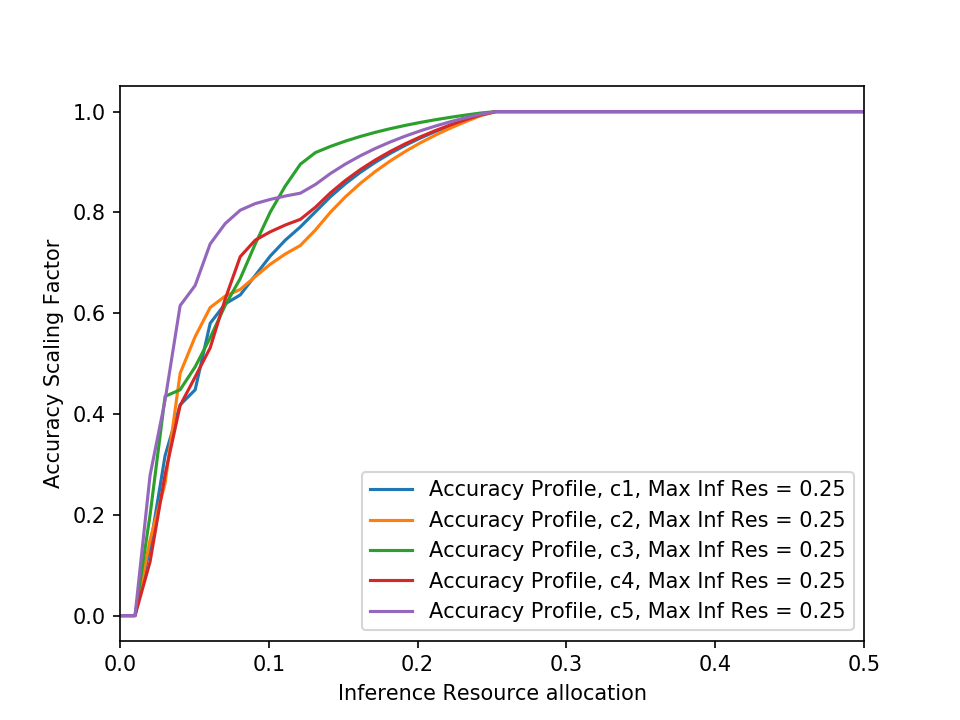

(0, 0.5)

In [15]:
for c in ["c{}".format(i) for i in range(1,6)]:
    fn, inv = get_infer_profile(max_inference_resources=0.25, camera=c)
    x = np.linspace(0,1,100) # 100 linearly spaced numbers
    y = [fn(v) for v in x]
    plt.plot(x,y, label="Accuracy Profile, {}, Max Inf Res = 0.25".format(c))
plt.legend()
plt.xlabel('Inference Resource allocation')
plt.ylabel('Accuracy Scaling Factor')
plt.xlim([0,0.5])

# Figure 7 - Single Camera

<IPython.core.display.Javascript object>


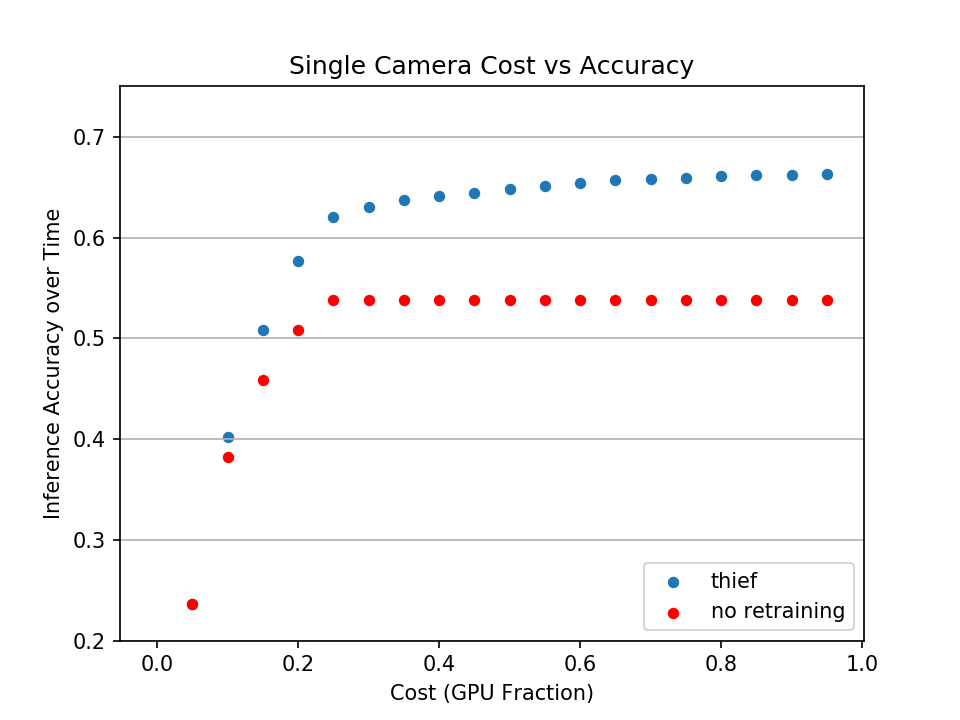

In [34]:
for PERIOD in [100]:#, 100]:#, 100, 200, 400]:
    sched_names = [sched_name for _, sched_name in schedulers_to_test if sched_name!='fair_random']
    const_res_data = df[df['period'] == PERIOD]
    ax = const_res_data.plot(x='resources', y='thief', kind='scatter', label='thief')
    
    const_res_data.plot(x='resources', y='inference_only', kind='scatter', color='red', label='no retraining', ax=ax)
    ax.set_xlabel("Cost (GPU Fraction)")
    ax.set_ylabel("Inference Accuracy over Time")
    ax.legend(loc='lower right')
    ax.grid(axis='y')
    ax.set_ylim([0.2,0.75])
    ax.set_title('Single Camera Cost vs Accuracy')
    plt.savefig('/tmp/schedcompare_{}.pdf'.format(PERIOD))